### Predicting Emotional Sentiment

In [5]:
import pandas as pd
import numpy as np
import nltk
import contractions
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
_ = nltk.download('stopwords', quiet=True)
_ = nltk.download('punkt_tab', quiet=True)


In [6]:
# Load the dataset
data = pd.read_csv('mental_health_data.csv')

# Preprocessing

# Remove the rows with missing values
data = data.dropna()

# Remove the rows with repeated entries in the statement column
data = data.drop_duplicates(subset='statement')

# Remove all non-letter and non-space characters from statement column
data['statement'] = data['statement'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

# Convert the statement column to lowercase
data['statement'] = data['statement'].str.lower()
data['status'] = data['status'].str.lower()

# Expand contractions
data['statement'] = data['statement'].apply(lambda x: contractions.fix(x))

In [7]:

# Tokenize the statement column
data['tokens'] = data['statement'].apply(word_tokenize)

# Remove stopwords
stop_words = set(stopwords.words('english'))
data['tokens'] = data['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Remove entries with an empty token vector
data = data[data['tokens'].map(len) > 0]

In [8]:
# print num of each sentiment
print(data['status'].value_counts())

status
normal                  15939
depression              15086
suicidal                10638
anxiety                  3617
bipolar                  2501
stress                   2293
personality disorder      895
Name: count, dtype: int64


In [9]:
sentiments = data['status'].unique()
sentiment_to_index = {sent: idx for idx, sent in enumerate(sentiments)}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['tokens'], data['status'], test_size=0.2, random_state=42)

train_total_sentences = {sent: len(y_train[y_train == sent]) for sent in sentiments}
# Build a dictionary of word frequencies per sentiment
train_word_freq = {} # key: word, value: list of frequency counts per sentiment
for tokens, sentiment in zip(X_train, y_train):
    for word in tokens:
        if word not in train_word_freq:
            train_word_freq[word] = [0] * len(sentiments)
        train_word_freq[word][sentiment_to_index[sentiment]] += 1

# Normalize frequencies
for word, freq_vector in train_word_freq.items():
    for sent, idx in sentiment_to_index.items():
        freq_vector[idx] /= train_total_sentences[sent]

# Map sentences to feature vectors
def sentence_to_vector(tokens, word_freq, sentiments):
    vector = np.zeros(len(sentiments))

    for token in tokens:
        if token in word_freq:
            vector += np.array(word_freq[token])

    # Normalize the vector
    return vector / len(tokens)

X_train_vec = X_train.apply(lambda tokens: sentence_to_vector(tokens, train_word_freq, sentiments))
X_test_vec = X_test.apply(lambda tokens: sentence_to_vector(tokens, train_word_freq, sentiments))

print(X_train_vec)


22776    [0.08860890576458405, 0.00577587560860688, 0.1...
2217     [0.0244587997435771, 0.0015145055980614328, 0....
34097    [0.09947071683350589, 0.007198575990785823, 0....
14877    [0.11313323712523549, 0.012254452078772132, 0....
44687    [0.09435047750546544, 0.009135647348306372, 0....
                               ...                        
11400    [0.10152264794998657, 0.009728984520880233, 0....
45278    [0.07268602988313032, 0.012553568623931432, 0....
38625    [0.10616329516026754, 0.012593154820180318, 0....
882      [0.0185249108272926, 0.006151510392126067, 0.0...
15916    [0.13874506194147201, 0.018485070589672442, 0....
Name: tokens, Length: 40775, dtype: object


In [10]:
X_train_array = np.vstack(X_train_vec.values)
X_test_array = np.vstack(X_test_vec.values)

# Initialize the SVM model with an RBF kernel (tune parameters as needed)
svm_model = SVC(kernel='rbf', random_state=42, class_weight='balanced')

# Fit the SVM model on the training data
svm_model.fit(X_train_array, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_array)

# Evaluate the model's performance
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.5261918775750442

Classification Report:
                       precision    recall  f1-score   support

             anxiety       0.50      0.69      0.58       720
             bipolar       0.43      0.68      0.53       541
          depression       0.65      0.38      0.48      3015
              normal       0.84      0.58      0.69      3205
personality disorder       0.10      0.62      0.18       185
              stress       0.21      0.49      0.29       447
            suicidal       0.52      0.56      0.54      2081

            accuracy                           0.53     10194
           macro avg       0.47      0.57      0.47     10194
        weighted avg       0.63      0.53      0.55     10194



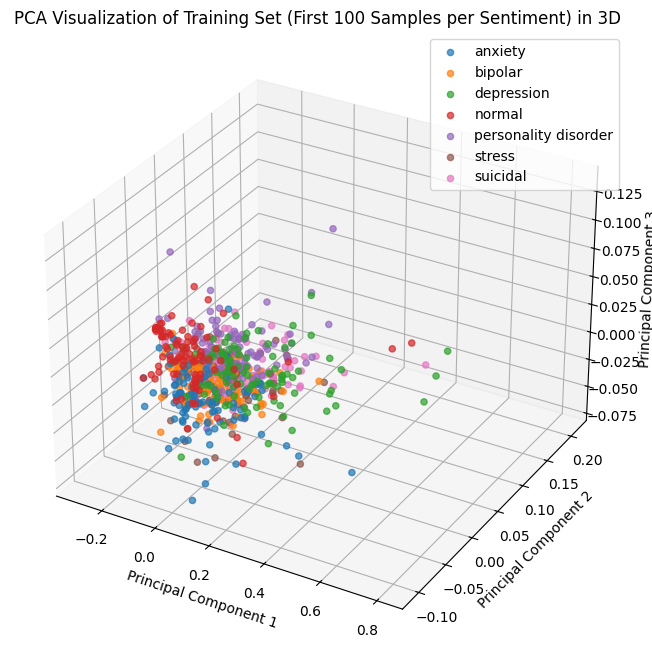

In [11]:

# Convert X_train_vec (a Series of numpy arrays) to a 2D numpy array
X_train_array = np.vstack(X_train_vec.values)

# Apply PCA to reduce to 3 dimensions
pca = PCA(n_components=3, random_state=42)
X_train_pca = pca.fit_transform(X_train_array)

# Create a 3D scatter plot with colors for each sentiment, using only the first 100 samples per sentiment
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
unique_sentiments = np.unique(y_train)
for sentiment in unique_sentiments:
    # Get indices for the current sentiment and limit to the first 100 entries
    indices = np.where(y_train == sentiment)[0][:100]
    ax.scatter(X_train_pca[indices, 0], X_train_pca[indices, 1], X_train_pca[indices, 2],
               label=sentiment, alpha=0.7)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("PCA Visualization of Training Set (First 100 Samples per Sentiment) in 3D")
ax.legend()
plt.show()
